In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from sklearn import datasets, linear_model
from sklearn.datasets import load_boston

# Part-1 Programming Review 编程回顾

##  1. Re-code the Linear-Regression Model using scikit-learning(10 points)

In [3]:
dataset = load_boston()

In [4]:
# Use 'RM' feature
boston_X = dataset['data'][:, np.newaxis, 5]
boston_y = dataset['target']

In [5]:
# Split the data into training/testing sets
boston_X_train = boston_X[:-20]
boston_X_test = boston_X[-20:]

# Split the data into training/testing sets
boston_y_train = boston_y[:-20]
boston_y_test = boston_y[-20:]

In [6]:
lregr = linear_model.LinearRegression()

In [7]:
# 训练模型
lregr.fit(boston_X_train, boston_y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [8]:
# 使用测试集进行预测
boston_y_pred = lregr.predict(boston_X_test)

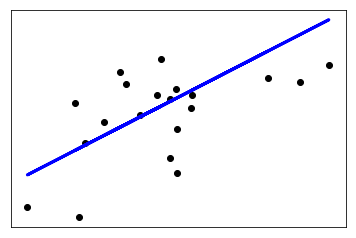

In [9]:
# 可视化
plt.scatter(boston_X_test, boston_y_test,  color='black')
plt.plot(boston_X_test, boston_y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

## 2. Complete the unfinished KNN Model using pure python to solve the previous Line-Regression problem. (8 points) 

In [10]:
import statistics

In [11]:
class KNearestNeighborsRegression:
    def __init__(self, n_neighbors):
        self.n_neighbors = n_neighbors
    def fit(self, X: list, y: list):
        self.X_y = list(zip(X, y))
    def predict(self, X: list):
        y = []
        for x in X:
            n_X_y = sorted(self.X_y, key=lambda x_y: abs(x_y[0] - x))[:self.n_neighbors]
            _, n_y = zip(*n_X_y)
            y.append(statistics.mean(n_y))
        return y

In [12]:
# Use 'RM' feature
boston_X = list(dataset['data'][:, 5])
boston_y = list(dataset['target'])

In [13]:
# Split the data into training/testing sets
boston_X_train = boston_X[:-20]
boston_X_test = boston_X[-20:]

# Split the data into training/testing sets
boston_y_train = boston_y[:-20]
boston_y_test = boston_y[-20:]

In [14]:
knn = KNearestNeighborsRegression(50)

In [15]:
# 训练模型
knn.fit(boston_X_train, boston_y_train)

In [16]:
# 使用测试集进行预测
boston_y_pred = knn.predict(boston_X_test)

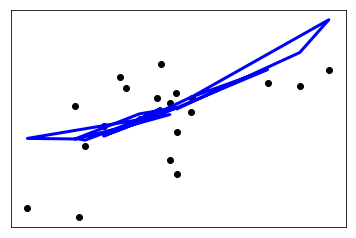

In [17]:
# 可视化
plt.scatter(boston_X_test, boston_y_test,  color='black')
plt.plot(boston_X_test, boston_y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

## 3. Re-code the Decision Tree, which could sort the features by salience. (12 points)

### 信息熵

$$Entropy=-\sum_{i=0}^{n}Pr(x_i)\log(Pr(x_i))$$

In [18]:
from collections import Counter
import math
def entropy(seq):
    counter = Counter(seq)
    n = len(seq)
    return -sum([counter[e] / n * math.log(counter[e] / n) for e in set(seq)])

In [19]:
import pandas as pd
def get_partition_feature(X):
    """获取划分特征"""
    feature_indexs = list(X.columns)[:-1]
    # 信息增益率
    gain_ratios = []

    y_entropy = entropy(X.iloc[:, -1])
    n = X.shape[0]
    for index in feature_indexs:
        # 信息增益
        info_gain = y_entropy - sum([sub.shape[0] / n * entropy(sub.iloc[:, -1]) for _, sub in X.groupby(index)])
        # 属性固有值
        iv = - sum([sub.shape[0] / n * math.log(sub.shape[0] / n) for _, sub in X.groupby(index)])
        gain_ratios.append((index, info_gain / iv))
    return sorted(gain_ratios, key=lambda gain_ratio: gain_ratio[1])[-1][0]

In [20]:
X = pd.DataFrame({
    'gender':['F', 'F', 'F', 'F', 'M', 'M', 'M'],
    'income': ['+10', '-10', '+10', '+10', '+10', '+10', '-10'],
    'family_number': [1, 1, 2, 1, 1, 1, 2],
    'bought': [1, 1, 1, 0, 0, 0, 1]})

In [21]:
X

,gender,income,family_number,bought
0,F,+10,1,1
1,F,-10,1,1
2,F,+10,2,1
3,F,+10,1,0
4,M,+10,1,0
5,M,+10,1,0
6,M,-10,2,1


In [22]:
get_partition_feature(X)

'family_number'

In [23]:
class Node:
    def __init__(self, feature):
        self.feature = feature
        self.children = {}
    def addChild(self, value, child):
        self.children[value] = child
    def __str__(self):
        s = str(self.feature) + '\n'
        for key, value in self.children.items():
            tmp = '|__(' + str(key) + ')__'
            if isinstance(value, Node):
                tmp += value.__tree_format_str(' ' * len(tmp))
            else:
                tmp += str(value)
            s += tmp + '\n'
        return s
    def __tree_format_str(self, placeholder):
        s = str(self.feature) + '\n'
        for key, value in self.children.items():
            tmp = placeholder + '|__(' + str(key) + ')__'
            if isinstance(value, Node):
                tmp += value.__tree_format_str(' ' * len(tmp))
            else:
                tmp += str(value)
            s += tmp + '\n'
        return s

In [24]:
from collections import deque, Counter
from icecream import ic
def build_decision_tree(X):
    """构建决策树"""
    decision_tree = Node(None)
    q = deque()
    q.append((X, decision_tree, 'head'))
    while q:
        e = q.popleft()
        if (e[0].shape[1] == 2):
            feature = e[0].columns[0]
            node = Node(feature)
            for _, g in e[0].groupby(feature):
                child = Counter(list(g.iloc[:, -1])).most_common(1)[0][0]
                node.addChild(g[feature].values[0], child)
        else:
            partition_feature = get_partition_feature(e[0])
            node = Node(partition_feature)
            for _, g in e[0].groupby(partition_feature):
                types = g.iloc[:, -1].values
                if len(set(types)) == 1:
                    node.addChild(g[partition_feature].values[0], types[0])
                else:
                    q.append((g.drop(partition_feature, axis=1), node, g[partition_feature].values[0]))
        
        e[1].addChild(e[2], node)
                             
    return decision_tree.children['head']

In [25]:
decision_tree = build_decision_tree(X)

In [26]:
# 持续的特征选则
print(decision_tree)

family_number
|__(2)__1
|__(1)__income
        |__(-10)__1
        |__(+10)__gender
                  |__(F)__1
                  |__(M)__0





## 4. Finish the K-Means using 2-D matplotlib (8 points) 

In [27]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

In [28]:
n_samples = 1500
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state)

In [29]:
# K-Means模型训练和预测
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X)

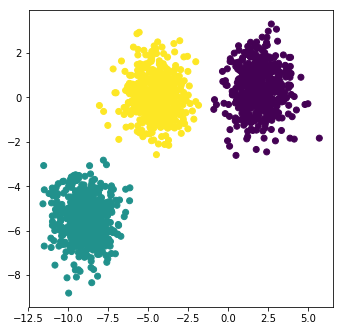

In [30]:
# 可视化
plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)

# Part-2 Question and Answer

#### 1. What's the *model*? why  all the models are wrong, but some are useful? (5 points) 

模型是指从数据（经验）中学习的结果，对应了关于数据的某种潜在的规律。模型只是对数据在特定场景的抽象，只包含了数据一部分特征。所以模型只反映了事物的局部特征，并不能表示整个事务。

#### 2. What's the underfitting and overfitting? List the reasons that could make model overfitting or underfitting. (10 points)

欠拟合是指模型对训练样本的一般性质尚未学好，通常是由于学习能力低下而造成的；过拟合是指模型将训练样本自身的一些特点当作了所有潜在样本都会有的一般性质，导致泛化性能下降，通常是由于学习能力过于强大，以至于把训练样本所包含的不太一般的特性都学到了。
欠拟合产生的可能因素：（1）模型复杂度过低（2）特征量过少
过拟合产生的可能因素：（1）样本数量太少（2）样本噪音干扰过大（3）特征量过太多，模型复杂度过高

#### 3. What's the precision, recall, AUC, F1, F2score. What are they mainly target on? (12')

precision（查准率、准确率）用于表示预测正例中的真正例的比率，用于度量模型预测的结果中有多少是正确结果。
recall（查全率、召回率）用于表示所有的正例中被预测出来的比率，用于度量模型预测出正确结果的能力。
查准率和查全率是一对矛盾的度量，一般来说，查准率高时，查全率往往偏低；而查全率高时，查准率往往偏低，F1是综合考虑查准率、查全率的性能度量，是基于查准率与查全率的调和平均定义的，F1越大，性能越优；F2_Score是查准率与查全率的加权调和平均，更偏向于查全率有更大的影响。
AUC表示ROC曲线的面积，模型泛化性能的度量，AUC越大表示模型泛化性能越好

#### 4. Based on our course and yourself mind, what's the machine learning?  (8')

机器学习致力于研究如何通过计算的手段，利用经验来改善系统自身的性能，即从数据中提取知识（模型）。传统的分析式编程是基于决策规则来处理数据的，需要人为的制定决策规则，决策逻辑只适用于单一领域和单项任务。如果任务稍有变化，就可能需要重新实现整个系统。并且制定规则，需要对决策过程有很深刻的理解。机器学习能够将决策过程自动化，通过经验（数据）泛化出决策过程（产生模型），在没有预先制定规则的情况下，能够对输入给出相应输出。

#### 5. "正确定义了机器学习模型的评价标准(evaluation)， 问题基本上就已经解决一半". 这句话是否正确？你是怎么看待的？ (8‘)

判断机器学习模型泛化能力需要选择一个能反映预测能力的评价指标，不同的机器学习任务有着不同的评价指标，同一机器学习任务也有着不同的评价指标，每个指标的着重点不一样，并且很多指标可以对多种不同的机器学习模型进行评价，所以选择一个合适的评价指标评估模型的泛化能力非常重要，可以达到事半功倍的效果。例如，在垃圾邮件检测是一个二分类问题，可以使用准确率（Accuracy）、对数损失函数（log-loss）、AUC等评价方法。

# Part-03 Programming Practice

1. In our course and previous practice, we complete some importance components of Decision Tree. In this problem, you need to build a **completed** Decision Tree Model. You show finish a `predicate()` function, which accepts three parameters **<gender, income, family_number>**, and outputs the predicated 'bought': 1 or 0.  (20 points)

In [31]:
class DecisionTree:
    def fit(self, X, y):
        df = pd.DataFrame(X)
        df[df.shape[1]] = y
        self.head = build_decision_tree(df)

    def predict(self, X: list):
        current_node = self.head
        while True:
            value = str(X[current_node.feature])
            if isinstance(current_node.children[value], Node):
                current_node = current_node.children[value]
            else:
                return current_node.children[value]

In [32]:
dt = DecisionTree()

In [33]:
# 模型训练
dt.fit(np.array([['F', 'F', 'F', 'F', 'M', 'M', 'M'], ['+10', '-10', '+10', '+10', '+10', '+10', '-10'], [1, 1, 2, 1, 1, 1, 2]]).T, [1, 1, 1, 0, 0, 0, 1])

In [34]:
# 预测
dt.predict(['M', '-10', 1])

1

2. 将上一节课(第二节课)的线性回归问题中的Loss函数改成"绝对值"，并且改变其偏导的求值方式，观察其结果的变化。(19 point)

## Linear Regression 

### linear function
$$ y = k*rm + b$$

In [35]:
def price(rm, k, b):
    return k * rm + b

### loss function(absolute loss)
$$ loss = \frac{1}{n} \sum{|y_i - \hat{y_i}|} = \frac{1}{n} \sum{|y_i - (kx_i + b_i)|}$$

In [36]:
def loss(y, y_hat):
    n = len(y)
    return sum([abs(y[i] - y_hat[i]) for i in range(n)]) / n

### gradient descent
#### partial derivatives

$$ \frac{\partial{loss}}{\partial{k}} = \frac{1}{m}(\sum_{y_i>\hat{y_i}}{-x_i} + \sum_{y_i<\hat{y_i}}{x_i})$$

$$ \frac{\partial{loss}}{\partial{b}} = \frac{1}{m}(\sum_{y_i>\hat{y_i}}{-1} + \sum_{y_i<\hat{y_i}}{1})$$


In [37]:
def partial_derivative_k(X, y, y_hat):
    n = len(y)
    pds_sum = 0
    for X_i, y_i, y_hat_i in zip(X, y, y_hat):
        if y_i > y_hat_i:
            pds_sum += -X_i
        elif y_i < y_hat_i:
            pds_sum += X_i
        else:
            # 偏导数不存在
            n -= 1
    return pds_sum / n

In [38]:
def partial_derivative_b(y, y_hat):
    n = len(y)
    pds_sum = 0
    for y_i, y_hat_i in zip(y, y_hat):
        if y_i > y_hat_i:
            pds_sum += -1
        elif y_i < y_hat_i:
            pds_sum += 1
        else:
            # 偏导数不存在
            n -= 1
    return pds_sum / n

### training model 

In [39]:
dataset = load_boston()
X, y = dataset['data'], dataset['target']
X_rm = X[:, 5]

In [40]:
import random
def fit(X, y, iteration_num, learning_rate=1e-3):
    #initialized parameters
    k = random.random() * 200 - 100  # -100 100
    b = random.random() * 200 - 100  # -100 100
    
    losses = []
    for i in range(iteration_num):

        y_pred = [price(x, k, b) for x in X]

        losses.append(loss(y, y_pred))

        k = k + (-1 * partial_derivative_k(X, y, y_pred)) * learning_rate
        b = b + (-1 * partial_derivative_b(y, y_pred)) * learning_rate
    
    return k, b, losses

In [69]:
k, b, losses = fit(X_rm, y, 5000)

In [70]:
print('k={}, b={}'.format(k, b))

k=13.576922269798887, b=-62.615843736305386


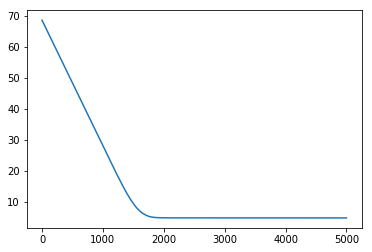

In [71]:
plt.plot(list(range(5000)), losses)

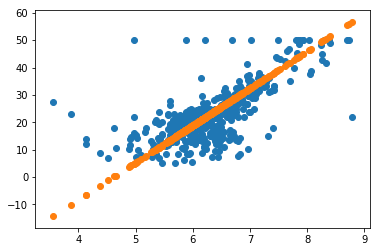

In [72]:
y_pred = [price(rm, k, b) for rm in X_rm]

plt.scatter(X_rm, y)
plt.scatter(X_rm, y_pred)